# 一元函数数值导数简要介绍

在这一节中，我们将会简单地介绍在我们工作中可能会使用到的数值导数方法。

在这里我们不引入复杂的化学问题，几乎单纯地从非常基础的数学角度来阐释问题。但作为仅仅关心 XYG3 二阶梯度的文档，这一节将会是后面几节的基础与铺垫。在这份课题中，数值导数的意义是可以用来验证解析导数的正确性。

In [1]:
%matplotlib notebook

import numpy as np
from functools import partial
from pyscf import gto, scf
import matplotlib.pyplot as plt

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.set_printoptions(5, linewidth=150, suppress=True)

我们在这一节中，只讨论一元函数的导数问题。关于更高维度的向量数值导数、我们会结合具体的分子来进行说明。

## 用于讨论的 Morse 函数

我们现在拿一个化学中经常使用的 Morse 势能函数来举例子。其中的参数仅仅是用于演示用途，而没有实际的物理意义。

$$
f(x) = \left( 1 - e^{1 - x} \right)^2 - 1
$$

In [2]:
def f(x):
    return (1 - np.exp(1 - x))**2 - 1

该函数的精确 (解析) 一阶导数可以表示为 `f_p(x)` $f'(x)$：

$$
f'(x) = \frac{\partial f(x)}{\partial x} = 2 e^{1 - x} \left( 1 - e^{1 - x} \right)
$$

In [3]:
def f_p(x):
    return 2 * np.exp(1 - x) * (1 - np.exp(1 - x))

该函数 $f(x)$ 在 $x = 1$ 处取到极小值 (即 $f'(1) = 0$)。函数显示为蓝色曲线，一阶导数显示为橙色曲线：

<IPython.core.display.Javascript object>


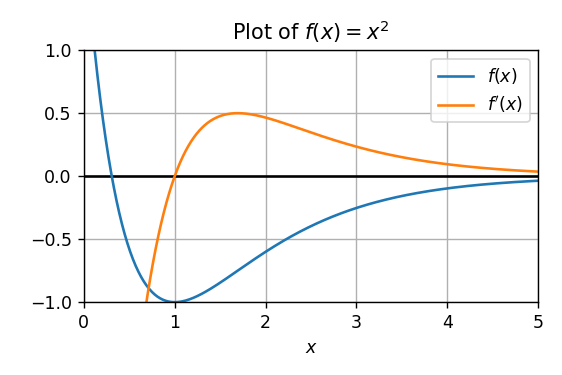

In [4]:
xlist = np.arange(0, 5, 0.01)
ylist, yplist = f(xlist), f_p(xlist)

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.plot([0, 5], [0, 0], color="black")
ax.plot(xlist, ylist, label="$f(x)$")
ax.plot(xlist, yplist, label="$f'(x)$")
ax.set_xlim(0, 5), ax.set_ylim(-1, 1)
ax.set_title(r"Plot of $f(x) = x^2$")
ax.set_xlabel(r"$x$")
ax.legend(), ax.grid()
fig.tight_layout()
fig.show()

## 三点差分一阶数值导数

我们首先从最简单的情况开始讨论。对于数值导数而言，最简单的情形是三点差分。

对于一阶导数，如果我们希望得到 $x = 3$ 的导数即 $f'(3)$，并且已经知道了整个曲线的形状，我们可以用下面图示的方法：

<IPython.core.display.Javascript object>


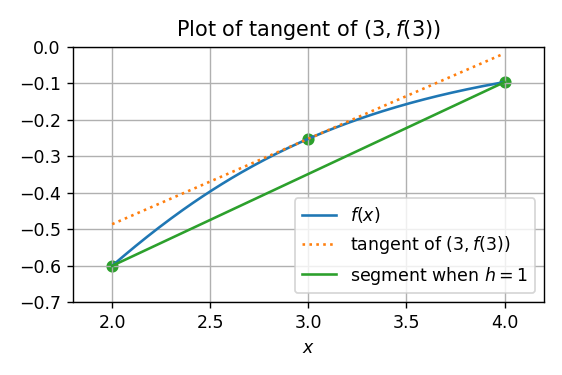

In [5]:
xlist = np.arange(2, 4, 0.01)
ylist = f(xlist)
ytlist = f_p(3) * (xlist - 3) + f(3)

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.plot(xlist, ylist, label="$f(x)$")
ax.plot(xlist, ytlist, label="tangent of $(3, f(3))$", linestyle=":")
ax.scatter([2, 3, 4], [f(2), f(3), f(4)], c="C2")
ax.plot([2, 4], [f(2), f(4)], c="C2", label="segment when $h = 1$")
ax.set_xlim(1.8, 4.2), ax.set_ylim(-0.7,-0.0)
ax.set_title(r"Plot of tangent of $(3, f(3))$")
ax.set_xlabel(r"$x$")
ax.legend(), ax.grid()
fig.tight_layout()
fig.show()

上面绿色的三个点与线段，可以用来估计 $f(x)$ 在 $x = 3$ 处的导数 (点 $(3, f(3))$ 处曲线切线的斜率)。我们定义函数 `f_d3(x, h)` $f^\mathrm{d} (x, h)$

$$
f^\mathrm{d} (x, h) = \frac{f(x + h) - f(x - h)}{2h}
$$

In [6]:
def f_d3(x, h):
    return (f(x + h) - f(x - h)) / (2 * h)

我们说，该函数的意义是取绿色线段的斜率。对于上图而言，$h$ 的取值是 $1$，那么绿色线段左右两个点就是 $(1 - h, f(1 - h)) = (2, f(2))$ 与 $(1 + h, f(1 + h)) = (4, f(4))$。这两个线段端点的斜率即

$$
f^\mathrm{d} (3, 1) = \frac{f(4) - f(2)}{4 - 2} \simeq 0.2517
$$

In [7]:
f_d3(3, 1)

0.2516641072736052

我们可以估计地认为，函数 $f(x)$ 在 $x = 3$ 处切线的斜率 (数值导数) 接近于 $0.2517$。从肉眼上，我们也确实会觉得绿色的线段 (估计的导数) 与橙色的切线 (解析的导数) 是非常接近的。实际上，解析的导数是 $f'(3) \simeq 0.2340$。

In [8]:
f_p(3)

0.23403928869575705

我们会说，若 $h$ 的值越小，或者说绿色的点之间的距离越小，那么我们所求得的斜率 (数值导数) 会越精确。事实上，

$$
\lim_{h \rightarrow 0} f^\mathrm{d} (x, h) = f'(x)
$$

并且数学分析或数值分析可以告诉我们，$|f^\mathrm{d} (x, h) - f'(x)| = o(h)$，因此函数 $f^\mathrm{d}(x, h)$ 对 $f'(x)$ 的逼近精度随 $h$ 越小而线性地更精确。

但事实上，从程序的结果而言并非如此。我们可以对 $x = 3$ 时，$|f^\mathrm{d} (3, h) - f'(3)|$ 的值作图，发现当 $h = 10^{-5}$ 左右时，才能获得比较好的数值导数的精度 ($10^{-10}$ 左右的精度)。因此，一般而言，用于求数值导数的差分值 $h$：

- $h$ 较大的情况，数值导数的精度受制于 $|f^\mathrm{d} (x, h) - f'(x)|$；

- $h$ 较小的情况，数值导数的精度受制于计算机本身的精度 (机器精度)；若计算机可以提供相当高的机器精度，那么 $h$ 较小时也可以得到良好的数值精度。

但我们一般在运算时只使用双浮点数，因此我们我们也不能选择太过小的 $h$ 值来计算数值导数。选取一个合适的 $h$ 值会是之后始终会遇到的问题。

<IPython.core.display.Javascript object>


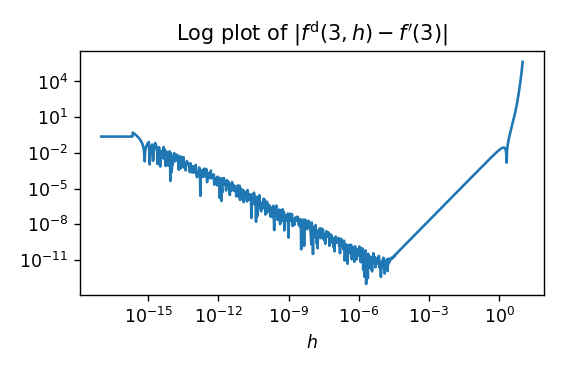

In [9]:
hlist = np.logspace(-17, 1, 1000)
ylist = np.abs(f_d3(3, hlist) - f_p(3))

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.plot(hlist, ylist)
ax.set_xscale("log"), ax.set_yscale("log")
ax.set_xlabel(r"$h$")
ax.set_title("Log plot of $|f^\mathrm{d} (3, h) - f'(3)|$")
fig.tight_layout()
fig.show()

我们指出，尽管三点差分声称是“三点”，但一阶梯度的计算只使用了两个点。但它被称为三点差分，是由于其数学推导而致使的。

## 五点差分一阶数值导数

五点差分并不像三点差分一样，有直观的几何解释。我们仍然用 $f^\mathrm{d} (x, h)$ 记号表示数值导数，但程序的函数写为 `f_d5(x, h)`：

$$
f^\mathrm{d} (x, h) = \frac{f(x - 2h) - 8 f(x - h) + 8 f(x + h) - f(x + 2h)}{12 h}
$$

In [10]:
def f_d5(x, h):
    return (f(x - 2 * h) - 8 * f(x - h) + 8 * f(x + h) - f(x + 2 * h)) / (12 * h)

我们仍然先拿 $x = 3, h = 1$ 的情况来讨论。我们看到，$f'(3) \simeq 0.2340$，而计算代价低的三点差分大约是 $0.2517$，代价较高的五点差分大约是 $0.2552$。

In [11]:
f_p(3), f_d3(3, 1), f_d5(3, 1)

(0.23403928869575705, 0.2516641072736052, 0.25524346096060413)

可见代价更高的五点差分并不一定会给出更好的结果。但是五点差分有可能达到更低的逼近精度：在 $x = 3, h = 10^{-3}$ 时，五点差分的数值精度可以达到 $10^{-13}$ 量级。

In [12]:
f_d3(3, 1e-3) - f_p(3), f_d5(3, 1e-3) - f_p(3)

(2.0690889585006644e-08, -1.3128387266192476e-14)

我们可以绘制 $x = 3$ 时，不同的逼近参数 $h$ 下，三点差分与五点差分的比较：

<IPython.core.display.Javascript object>


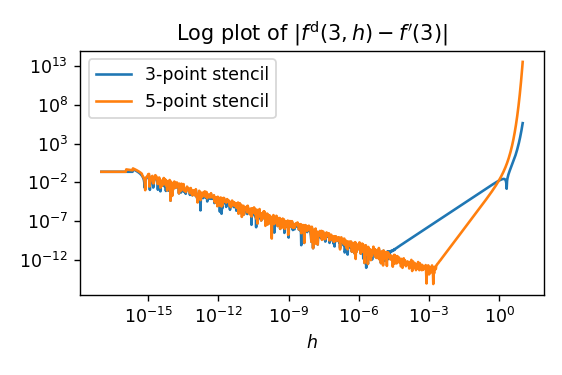

In [13]:
hlist = np.logspace(-17, 1, 1000)
y3list = np.abs(f_d3(3, hlist) - f_p(3))
y5list = np.abs(f_d5(3, hlist) - f_p(3))

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.plot(hlist, y3list, label="3-point stencil")
ax.plot(hlist, y5list, label="5-point stencil")
ax.set_xscale("log"), ax.set_yscale("log")
ax.set_xlabel(r"$h$")
ax.set_title("Log plot of $|f^\mathrm{d} (3, h) - f'(3)|$")
ax.legend()
fig.tight_layout()
fig.show()

一般而言，

- 五点差分的计算代价相对三点差分来说更大。对于一元函数的一阶导数而言，五点差分的代价是三点差分的两倍；但随着函数的未知元数量增大，其计算量还会进一步增大。

- 五点差分在逼近参数 $h$ 较大时，未必有更好的逼近表现。

- 五点差分从数学的角度来讲，$|f^\mathrm{d} (x, h) - f'(x)| = o(h^2)$；因此函数 $f^\mathrm{d}(x, h)$ 对 $f'(x)$ 的逼近精度随 $h$ 越小而平方地更精确 (三点差分是线性地更精确)。因此，若逼近精度不受制于机器精度，那么在 $h$ 较小的情况下，五点差分可以更快地逼近到解析导数。

- 但五点差分也更容易受制于机器精度影响，因此 $h$ 太小时，误差也未必比三点差分更小。在当前的例子中，$h$ 较小的情况下，五点与三点差分的误差近似相等；但对于以后实际的例子，太小的 $h$ 很可能带来更为灾难性的结果。

- 希望用较大的 $h$ 来逼近时，可以选用五点差分；用较小的 $h$ 逼近时，选用三点差分。

- 尽管称为五点差分，但实际上只使用了四个点。这也是由于五点差分的推导所导出的结果。

在以后，我们通常只使用三点查分来解决问题。

## 三点差分二阶数值导数

现在我我们考虑二阶导数的计算。我们首先指出，二阶导数 `f_pp(x)` $f''(x)$ 为

$$
f''(x) = 4 e^{2 - 2x} - 2 e^{1 - x}
$$

In [14]:
def f_pp(x):
    return 4 * np.exp(2 - 2 * x) - 2 * np.exp(1 - x)

二阶数值导数的一种做法，可以是通过一阶数值导数 $f^\mathrm{d} (x, h)$ 再求一次数值导数获得 (连续两次对函数 $f(x)$ 的数值导数)，其公式可以表达为 `f_dd(x, h)` $f^\mathrm{dd} (x, h)$：

$$
f^\mathrm{dd} (x, h) = \frac{f(x - h) - 2 f(x) + f(x + h)}{h^2}
$$

In [15]:
def f_dd(x, h):
    return (f(x - h) - 2 * f(x) + f(x + h)) / h**2

但还有一种做法：如果我们已知一阶解析导数，那么可以通过对解析导数再求一次数值导数获得 (仅一次数值导数)，其公式可以表达为 `f_pd(x, h)` $f'{}^\mathrm{d} (x, h)$：

$$
f'{}^\mathrm{d} (x, h) = \frac{f'(x + h) - f'(x - h)}{2h}
$$

In [16]:
def f_pd(x, h):
    return (f_p(x + h) - f_p(x - h)) / (2 * h)

我们仍然可以绘制数值导数与解析导数的在 $x = 3$ 时，不同的逼近参数 $h$ 的误差图：

<IPython.core.display.Javascript object>


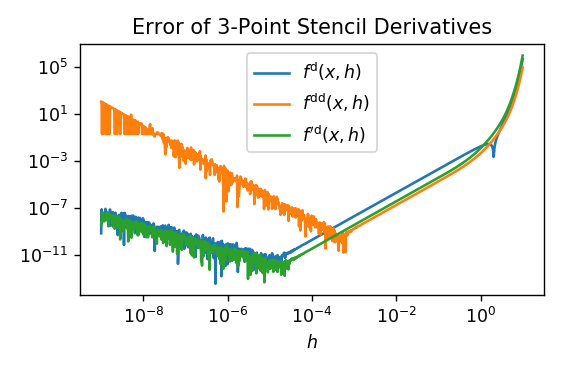

In [17]:
hlist = np.logspace(-9, 1, 1000)
dlist = np.abs(f_d3(3, hlist) - f_p(3))
ddlist = np.abs(f_dd(3, hlist) - f_pp(3))
pdlist = np.abs(f_pd(3, hlist) - f_pp(3))

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.plot(hlist, dlist, label=r"$f^\mathrm{d} (x, h)$")
ax.plot(hlist, ddlist, label=r"$f^\mathrm{dd} (x, h)$")
ax.plot(hlist, pdlist, label=r"$f'{}^\mathrm{d} (x, h)$")
ax.set_xscale("log"), ax.set_yscale("log")
ax.set_xlabel(r"$h$")
ax.set_title("Error of 3-Point Stencil Derivatives")
ax.legend()
fig.tight_layout()
fig.show()

我们在上图展示了三个数值导数的误差：

- 对 $f(x)$ 的两次数值导数 (橙色曲线) 与对 $f'(x)$ 的一次数值导数 (绿色曲线) 在稍大的 $h$ 值 ($h > 10^{-3}$) 时，误差相近；但两次数值导数 (橙色) 应机器精度导致的误差来得更快；

- 一般来说，我们很难判断不同函数的数值导数的误差大小 (拿当前的例子而言，我们不能判断对 $f(x)$ 还是对 $f'(x)$ 的数值导数误差是哪个更大)，但由于机器精度导致的数值导数振荡的 $h$ 值都在 $10^{-4.5}$ 左右。

基于上面的原因，我们以后不太会使用两次数值导数，并且通常 $h$ 的值设在 $3 \times 10^{-4}$。